In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
%matplotlib inline

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Load file and split input from target

In [3]:
with open("diabetes.txt","rb") as file:
    csvreader = csv.reader(file, delimiter=' ')
    table = np.asarray([row for row in csvreader], dtype=np.float)
xs = np.transpose(table[:,0:-1])
ys = table[:,-1]
# add constant
xs = np.vstack([xs,np.ones((1,xs.shape[1]))])

In [4]:
print xs.shape,ys.shape
print xs[:,:2]
print ys[:2]

(11, 442) (442,)
[[ 0.038076 -0.001882]
 [ 0.05068  -0.044642]
 [ 0.061696 -0.051474]
 [ 0.021872 -0.026328]
 [-0.044223 -0.008449]
 [-0.034821 -0.019163]
 [-0.043401  0.074412]
 [-0.002592 -0.039493]
 [ 0.019908 -0.06833 ]
 [-0.017646 -0.092204]
 [ 1.        1.      ]]
[ 151.   75.]


# define the individual bits: data splitting and regression

In [137]:
def split_set(input_outputs, split_at, do_shuffle=True):
    inputs, outputs=input_outputs
    num = inputs.shape[1]
    if do_shuffle:
        shuffling = np.random.permutation(num)
        shuffled  = (inputs[:,shuffling], outputs[shuffling])    
    else:
        shuffled = (inputs,outputs)
    return ((shuffled[0][:,:split_at], shuffled[1][:split_at]),
            (shuffled[0][:,split_at:], shuffled[1][split_at:]))

In [138]:
(trainall_dat,test_dat) = split_set((xs,ys),100,False)
(train_dat,val_dat) = split_set(trainall_dat,50,False)

perform  the actual ridge regression (Exercise 1)

In [139]:
def solve_ridge_regression(inputs,outputs,regularization):
    d,n = inputs.shape
    inverted = np.linalg.inv(np.dot(inputs,np.transpose(inputs))+regularization*np.eye(d))
    w = np.dot(np.dot(inverted,inputs), outputs)
    return w              

In [140]:
parameter = solve_ridge_regression(train_dat[0],train_dat[1],0.1)
parameter

array([   2.20039587, -118.21160875,  302.21019865,  161.14057166,
        -19.47586064, -150.77376856, -100.29914713,  134.12723768,
        437.63182099,    1.72070066,  147.54374456])

In [141]:
def evaluate_linear_model(inputs,outputs,parameters):
    predictions = np.dot(parameters,inputs)    
    return np.sum(np.square(predictions - outputs))/len(predictions)

In [142]:
evaluate_linear_model(test_dat[0],test_dat[1],parameter)

3411.4904222025825

Least Squares

In [143]:
lsm = solve_ridge_regression(train_dat[0], train_dat[1], 0)
lsm_train_error = evaluate_linear_model(train_dat[0],train_dat[1],lsm)
lsm_val_error   = evaluate_linear_model(val_dat[0],val_dat[1],lsm)

Ridge Regression

In [144]:
ls = range(-20,10)
learned_models = [ solve_ridge_regression(train_dat[0], train_dat[1], 2**l) for l in ls ]
train_errors= [ evaluate_linear_model(train_dat[0],train_dat[1],w) for w in learned_models]
val_errors= [ evaluate_linear_model(val_dat[0],val_dat[1],w) for w in learned_models]
min_val_idx = np.argmin(val_errors)

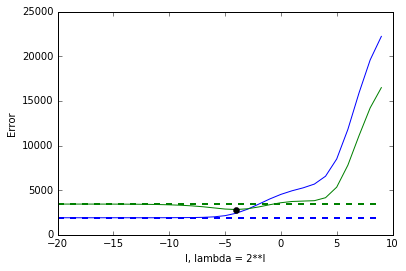

In [145]:
plt.plot(ls,train_errors)
plt.plot(ls,val_errors)

plt.plot([ls[0], ls[-1]], [lsm_train_error, lsm_train_error], color='b', linestyle='--', linewidth=2)
plt.plot([ls[0], ls[-1]], [lsm_val_error, lsm_val_error], color='g', linestyle='--', linewidth=2)
plt.plot(ls[min_val_idx], val_errors[min_val_idx], color='k', marker='o')
plt.xlabel("l, lambda = 2**l")
plt.ylabel("Error")

# 2(a) Iterate over 50 experiments

In [146]:
def split_and_regress(data, split_size):
    (trainall_dat,test_dat) = split_set(data, 2*split_size, True)
    (train_dat, val_dat) = split_set(trainall_dat,split_size,False)
    ls = range(-20,10)
    learned_models = [ solve_ridge_regression(train_dat[0], train_dat[1], 2**l) for l in ls ]
    train_errors= [ evaluate_linear_model(train_dat[0], train_dat[1], w) for w in learned_models]
    val_errors= [ evaluate_linear_model(val_dat[0], val_dat[1], w) for w in learned_models]
    min_val_idx = np.argmin(val_errors)
    return (np.asarray(ls, dtype=float),
            np.asarray(train_errors),
            np.asarray(val_errors),
            min_val_idx)

In [119]:
runs = [ split_and_regress((xs, ys), 20) for i in range(0, 50)]

take out only the first three columns of runs (it is a list of arrays)

In [120]:
train_and_val_errors = np.asarray([ r[0:3] for r in runs])

Selection based on mean validation error

In [121]:
mean_val_errors=np.mean(train_and_val_errors[:,2],axis=0)
min_val_idx=np.argmin(mean_val_errors)
print min_val_idx, mean_val_errors[min_val_idx]

15 3876.74735312


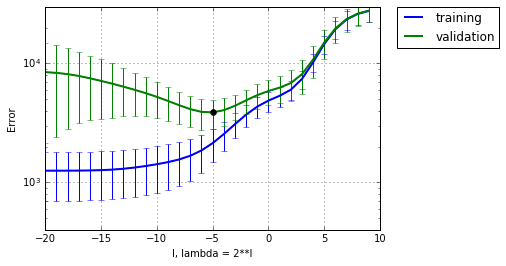

In [129]:
colors=['','b','g']
labels=['','training','validation']
plt.yscale('log')
plt.ylim([400,30000])
plt.grid(1)
ls=train_and_val_errors[0][0]
for k in [1,2]:
    mean_error=np.mean(train_and_val_errors[:,k], axis=0)
    std_error=np.std(train_and_val_errors[:,k], axis=0)
    plt.plot(ls, mean_error, color=colors[k], lw=2, label=labels[k])
    plt.errorbar(ls, mean_error, yerr=std_error, color=colors[k])
plt.plot(ls[min_val_idx], mean_val_errors[min_val_idx], color='k', marker='o')
plt.xlabel("l, lambda = 2**l")
plt.ylabel("Error")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Histogram of best lambdas

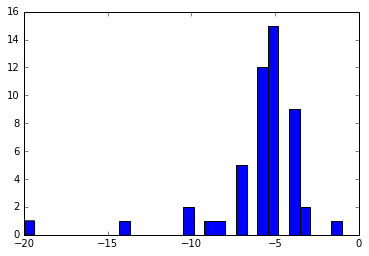

In [130]:
ls = runs[0][0]
cnts=plt.hist([ls[r[3]] for r in runs], bins=30)

# K-fold CV

In [188]:
def regress_and_select(train_dat, val_dat, ls):
    learned_models = [ solve_ridge_regression(train_dat[0], train_dat[1], 2**l) for l in ls ]
    train_errors= [ evaluate_linear_model(train_dat[0], train_dat[1], w) for w in learned_models]
    val_errors= [ evaluate_linear_model(val_dat[0], val_dat[1], w) for w in learned_models]
    min_val_idx=np.argmin(val_errors)
    return val_errors[min_val_idx], learned_models[min_val_idx]

In [189]:
def mask_out(array,idx):
    mask = np.ones(len(array), dtype=bool)
    mask[idx] = False
    return np.asarray(array)[mask]

In [190]:
def k_CV_regress(data, k, ls):
    (xs, ys) = data
    # split data
    chunks_xs = np.array_split(xs,k,axis=1)
    chunks_ys = np.array_split(ys,k,axis=0)
    error_and_models = [ 
        regress_and_select((np.hstack(mask_out(chunks_xs, leaveout)),
                            np.hstack(mask_out(chunks_ys, leaveout))),
                           (chunks_xs[leaveout],chunks_ys[leaveout]), ls)
                            for leaveout in range(0, k) ]
    errors,models = zip(*error_and_models)    
    return (np.mean(errors), errors, models )

In [191]:
(trainall_dat,test_dat) = split_set((xs,ys), 200, True)

Test 10-fold Cross validation

In [192]:
result=k_CV_regress(trainall_dat, 10, range(-20,10))
result[0], result[1]

(3036.7169486136077,
 (2874.9598499695903,
  2905.8647879160731,
  3595.3566946381106,
  3025.9207230565412,
  4589.2629079641711,
  2991.6124338988293,
  4582.7650636954077,
  1057.7373575891049,
  1953.7785707029502,
  2789.9110967052975))

In [193]:
test_errors = [ evaluate_linear_model(test_dat[0], test_dat[1], w) for w in result[2]]
np.mean(test_errors)

2964.2283236108065

In [194]:
def run(k):
    result=k_CV_regress(trainall_dat, k, range(-20,10))
    test_errors = [ evaluate_linear_model(test_dat[0], test_dat[1], w) for w in result[2]]
    print " K: %i mean validation error: %f\t test error: %f" % (k, 
                                                                 result[0], 
                                                                 np.mean(test_errors))
    return (k, result[0], np.mean(test_errors))

In [195]:
kvcv = np.asarray([ run(k) for k in [2,4,5,10,20]])

 K: 2 mean validation error: 2971.879531	 test error: 2989.127423
 K: 4 mean validation error: 3168.679646	 test error: 2998.065728
 K: 5 mean validation error: 3049.306265	 test error: 2970.640130
 K: 10 mean validation error: 3036.716949	 test error: 2964.228324
 K: 20 mean validation error: 2893.725104	 test error: 3269.492114


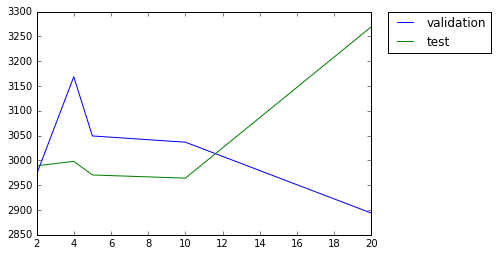

In [196]:
plt.plot(kvcv[:,0],kvcv[:,1], label="validation")
plt.plot(kvcv[:,0],kvcv[:,2], label="test")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)